In [1]:
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

plt.rcParams['axes.formatter.use_locale'] = True

# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [2]:
import itertools
import math
def gen_bars(df, col, err):
  df = df.copy()
  df[col+'_hb'] = df[col] + err
  df[col+'_lb'] = df[col] - err
  return df

def gen_col_with_bars(df, col, func, *params):
  lb = pd.Series([math.inf] * len(df), index=df.index)
  hb = pd.Series([-math.inf] * len(df), index=df.index)
  for i in itertools.product(*[[col+'_hb', col+'_lb'] for col in params]):
    val = df.apply(lambda x: func(**{key[:-3]: x[key] for key in i}), axis=1)
    lb = np.minimum(lb, val)
    hb = np.maximum(hb, val)
  df = df.copy()
  df[col] = df.apply(lambda x: func(**{key: x[key] for key in params}), axis=1)
  df[col+'_hb'] = hb
  df[col+'_lb'] = lb
  return df

def to_rus_str(col):
  return col.astype('str').str.replace('.', ',')

def gen_latex_col(df, col, round, err=None, mult=1):
  if round > 0:
    fround = lambda x: x.round(round)
  else:
    fround = lambda x: x.astype(int)

  if err is None:
    err = (df[col+'_hb'] - df[col+'_lb']) / 2
  err = to_rus_str(fround(err) * mult)
  newcol = to_rus_str(fround(df[col]) * mult)
  return "$" + newcol + " \\pm " + err + "$"

In [3]:
dfa = pd.read_csv('dataA.csv')
dfa['inc'] = dfa['volt'] > 0

In [4]:
dfa = gen_bars(dfa, 'current', 0.01)
dfa = gen_bars(dfa, 'volt', 0.01)

In [5]:
dfa

,volt,current,inc,current_hb,current_lb,volt_hb,volt_lb
0,24.993,110.57,True,110.58,110.56,25.003,24.983
1,22.077,108.40,True,108.41,108.39,22.087,22.067
2,18.946,105.03,True,105.04,105.02,18.956,18.936
3,16.017,99.78,True,99.79,99.77,16.027,16.007
4,13.140,91.70,True,91.71,91.69,13.150,13.130
5,10.204,80.37,True,80.38,80.36,10.214,10.194
6,8.000,69.92,True,69.93,69.91,8.010,7.990
7,5.992,58.40,True,58.41,58.39,6.002,5.982
8,3.999,46.03,True,46.04,46.02,4.009,3.989
9,1.993,31.85,True,31.86,31.84,2.003,1.983


In [6]:
def get_err_from_bars(df, col):
  return (df[col+'_hb'] - df[col+'_lb']) / 2

def get_errs(df, col):
  return np.vstack((df[col+'_hb'] - df[col],  df[col] - df[col+'_lb']))

(100,) (100,)


/tmp/ipykernel_987/1840785879.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_function, x, y)


Text(0.5, 1.0, 'Зависимость напряжения от тока')

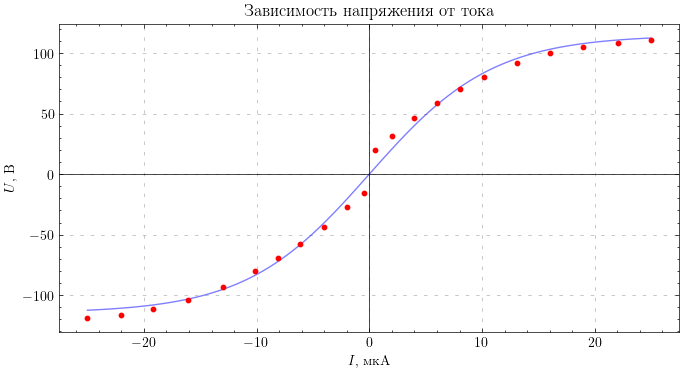

In [16]:
from scipy.optimize import curve_fit

def plot_volt_current(ax, df, label=None, color=None):
  y = df.current
  x = df.volt
  yerr = get_errs(df, 'current')
  xerr = get_errs(df, 'volt')

  def fit_function(x, a, b, c):
    return a * np.tanh(b * x)

  popt, pcov = curve_fit(fit_function, x, y)
  xp = np.linspace(x.min(), x.max(), 100)
  yp = fit_function(xp, *popt)
  print(xp.shape, yp.shape)

  sc, = ax.plot(xp, yp, label=label, c='blue', alpha=0.5)
  ax.scatter(x, y, s=10, zorder=10, c='red')
  # ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor=sc.get_color(),
  #             capsize=2, c=sc.get_color())
  ax.axhline(0, color='black', linewidth=0.5)
  ax.axvline(0, color='black', linewidth=0.5)

fig, ax = plt.subplots(figsize=(8, 4))
plot_volt_current(ax, dfa, )
plt.ylabel(r'$U$, B')
plt.xlabel(r'$I$, мкА')
plt.title(r'Зависимость напряжения от тока')